## Kaggle's section

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


## Libraries

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, roc_auc_score
import lightgbm as lgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

| Feature Name | Description |
| ------------ | ----------- |
|person_age	 | Age |
| person_income	| Annual Income|
| person_home_ownership |	Home ownership|
| person_emp_length	 |Employment length (in years)|
| loan_intent	|Loan intent|
| loan_grade	|Loan grade|
| loan_amnt|	Loan amount|
| loan_int_rate|	Interest rate|
| loan_status|	Loan status (0 is non default 1 is default)|
| loan_percent_income|	Percent income|
| cb_person_default_on_file	|Historical default|
| cb_preson_cred_hist_length|	Credit history length|

In [4]:
print('Number of rows and columns of the training set: ', df.shape)
df.head()

Number of rows and columns of the training set:  (58645, 13)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


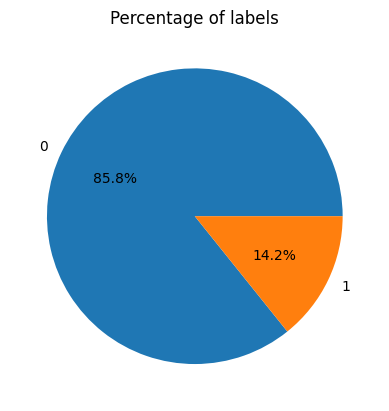

In [8]:
train_y_val = df['loan_status'].value_counts()
plt.pie(train_y_val, labels=train_y_val.index, autopct='%1.1f%%');
plt.title("Percentage of labels");

In [9]:
print('Number of rows and columns of the test set: ', df_test.shape)
df_test.head()

Number of rows and columns of the test set:  (39098, 12)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [10]:
cat_cols_df = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols_test = df_test.select_dtypes(include=['object', 'category']).columns.tolist()

print(cat_cols_df)
print(cat_cols_test)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [11]:
print("Info of the Training Set")
print(df.info())

print("----------")

print(df.isna().sum())

Info of the Training Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: flo

In [12]:
print("Info of the Test Set")
print(df_test.info())

print("----------")

print(df_test.isna().sum())

Info of the Test Set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB
None
-----

In [13]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [14]:
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

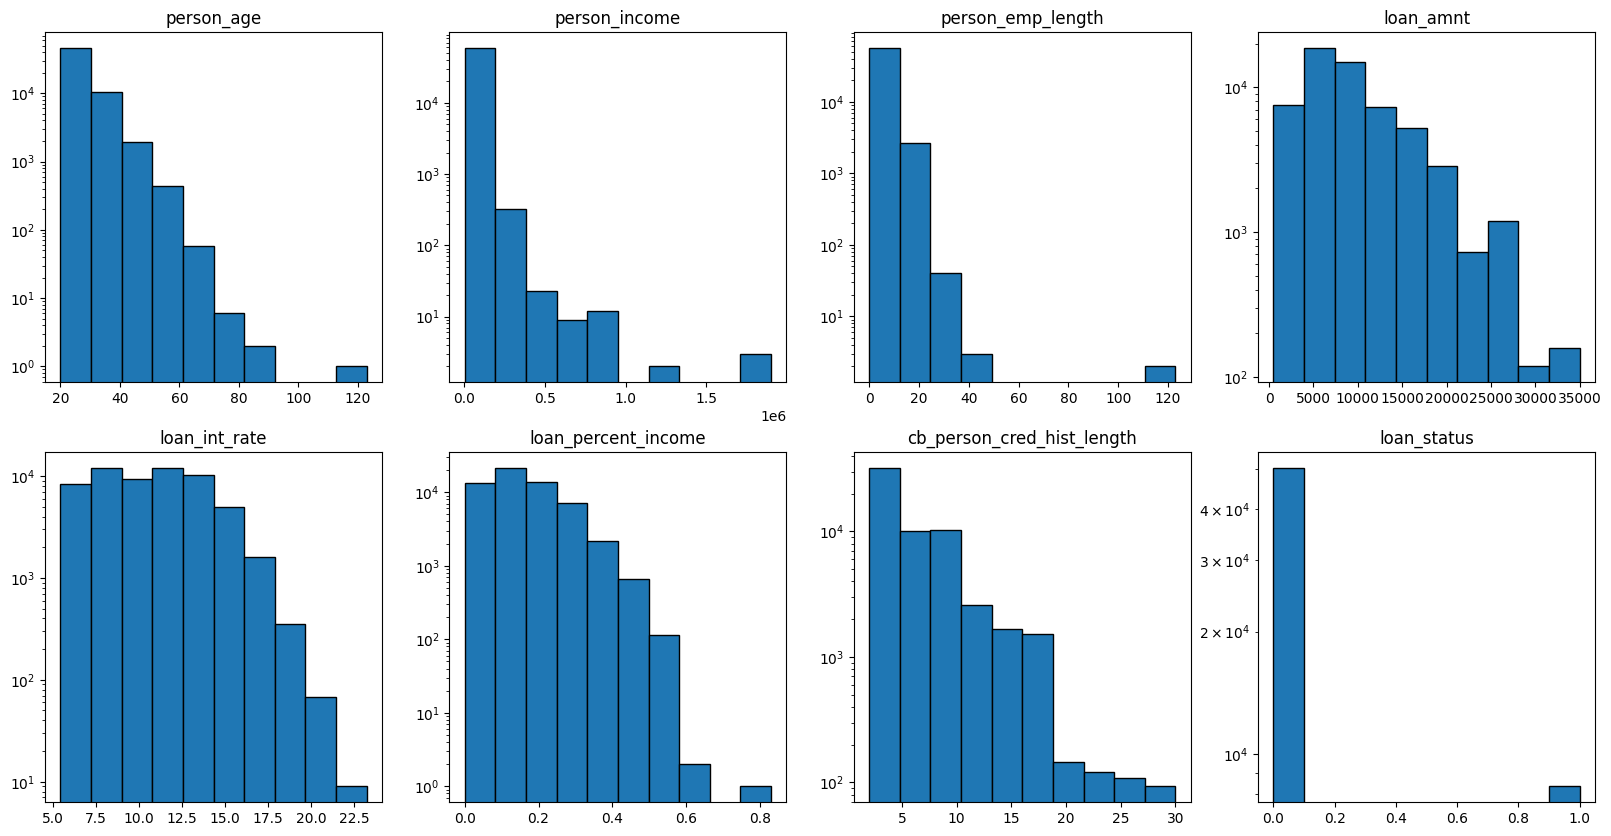

In [15]:
len_num_cols = len(num_cols)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))


for i in range(2):
    for j in range(4):
        axs[i ,j].hist(df[num_cols[4 * i + j]], log=True,edgecolor='black')
        axs[i ,j].set_title(num_cols[4 * i + j])
        

In [16]:
for col in cat_cols:
    count_dict = {}
    print(col, ': ', df[col].unique())

person_home_ownership :  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent :  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade :  ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file :  ['N' 'Y']


Check the `person_income`, `loan_amnt`, `loan_percent_income`

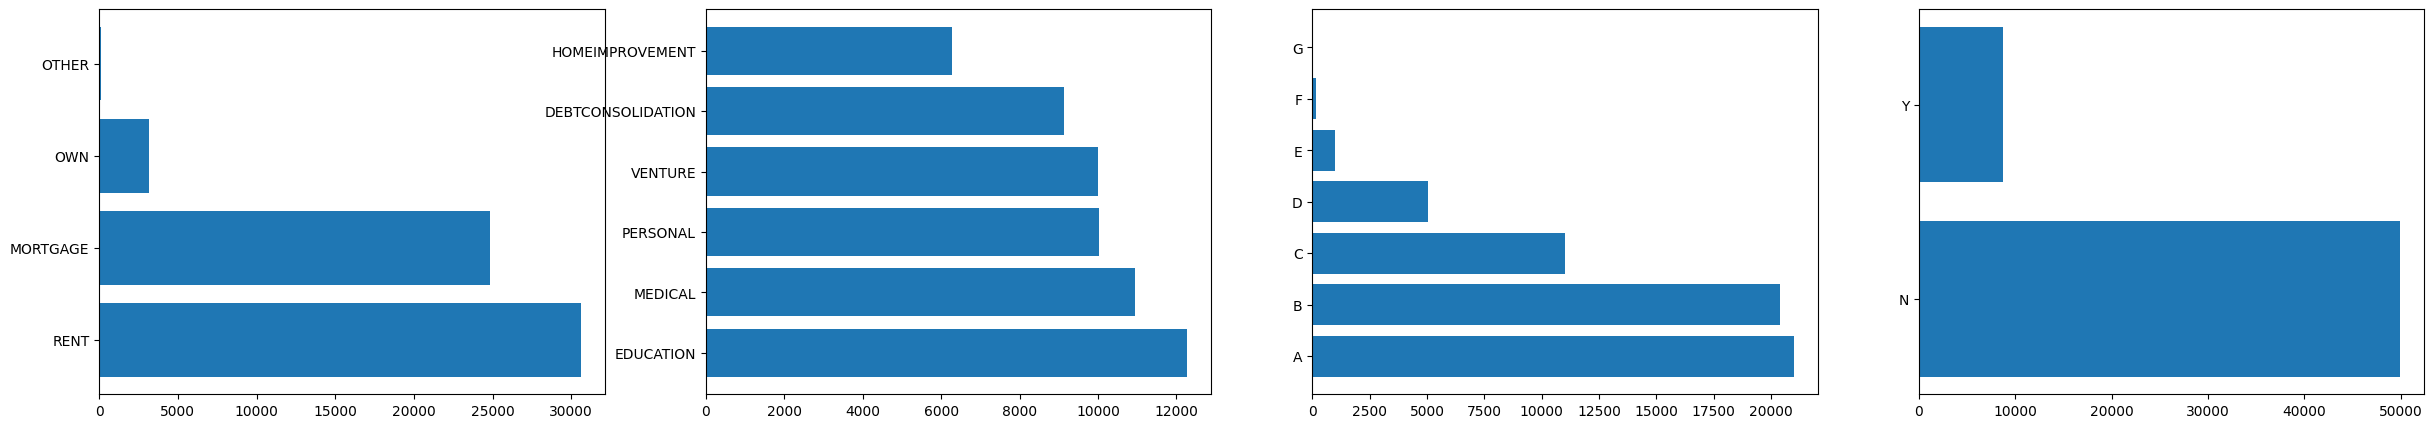

In [17]:
fig, axs = plt.subplots(1,4, figsize =(30, 5))
for i in range(4):
    stats = df[cat_cols[i]].value_counts()
    axs[i].barh(stats.index, stats)

## Prepare the data for ML

### Ordinal Encoder

In [18]:
ord_enc = OrdinalEncoder()

In [19]:
df[['person_home_ownership', 'loan_intent']] = ord_enc.fit_transform(df[['person_home_ownership', 'loan_intent']])

df_test[['person_home_ownership', 'loan_intent']] = ord_enc.transform(df_test[['person_home_ownership', 'loan_intent']])

In [20]:
loan_grade_mapping = {'A': 1,
                     'B': 2,
                     'C': 3,
                     'D': 4,
                     'E': 5,
                     'F': 6,
                     'G': 7}

df['loan_grade'].replace(loan_grade_mapping,inplace=True)
df['cb_person_default_on_file'].replace({'Y':1, 'N': 0},inplace=True)

df_test['loan_grade'].replace(loan_grade_mapping,inplace=True)
df_test['cb_person_default_on_file'].replace({'Y':1, 'N': 0},inplace=True)

In [21]:
ord_enc.categories_

[array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object),
 array(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
        'PERSONAL', 'VENTURE'], dtype=object)]

### Standard Scaler

In [22]:
scaler = StandardScaler()

df[['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length','loan_amnt','loan_int_rate']] = scaler.fit_transform(
    df[['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length', 'loan_amnt','loan_int_rate']])

df_test[['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length','loan_amnt','loan_int_rate']] = scaler.transform(
    df_test[['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length', 'loan_amnt','loan_int_rate']])

In [23]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,1.566200,-0.765768,3.0,-1.187200,1.0,2,-0.578306,0.267616,0.17,0,2.031798,0
1,1,-0.920057,-0.212128,2.0,0.328047,3.0,3,-0.937775,0.880532,0.07,0,-0.946489,0
2,2,0.240196,-0.929223,2.0,0.833130,4.0,1,-0.578306,-0.585854,0.21,0,1.039036,0
3,3,0.405947,0.156966,3.0,2.348377,5.0,2,0.500101,0.142396,0.17,0,-0.201917,0
4,4,-0.920057,-0.106673,3.0,-0.682117,3.0,1,-0.578306,-1.238314,0.10,0,-0.698298,0


In [24]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,-0.754307,0.130602,3.0,-0.429576,2.0,6,2.836651,1.674687,0.36,0,-0.946489
1,58646,-0.257055,0.842425,0.0,0.328047,4.0,3,0.140632,0.659750,0.10,1,-0.450108
2,58647,-0.257055,-0.897587,3.0,0.075506,5.0,5,-0.937775,2.145908,0.13,1,-0.946489
3,58648,0.903198,-0.370311,3.0,-0.177035,0.0,1,-0.398572,-0.585854,0.14,0,0.294464
4,58649,-0.257055,1.000608,0.0,0.833130,2.0,4,1.039305,1.859221,0.15,1,-0.450108


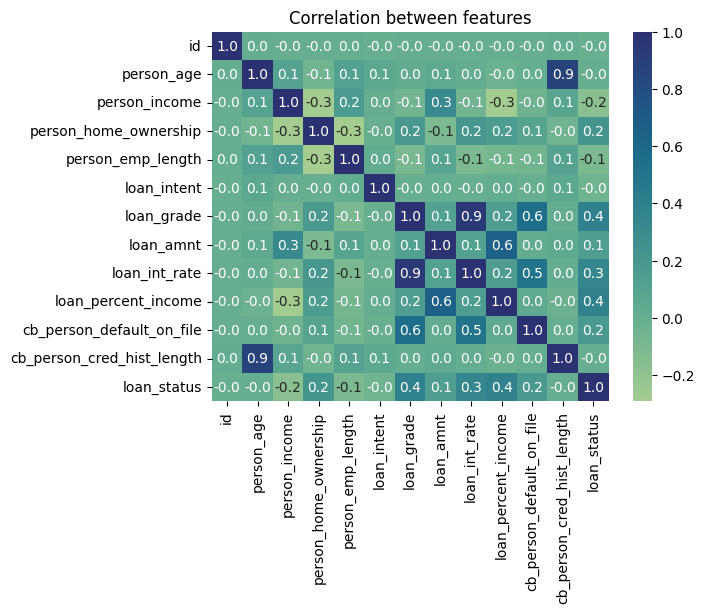

In [25]:
sns.heatmap(df.corr(), cmap="crest", annot=True, fmt=".1f")
plt.title('Correlation between features');

In [26]:
# X = df.drop(columns=['id', 'loan_status','cb_person_cred_hist_length', 'loan_grade'])
X = df.drop(columns=['id', 'loan_status'])
y = df['loan_status']

# X_test = df_test.drop(columns=['id', 'cb_person_cred_hist_length', 'loan_grade'])
X_test = df_test.drop(columns=['id'])

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [28]:
# train the model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_val = log_reg.predict(X_val)

print("ROC on the training set: ", roc_auc_score(y_train, y_pred_train))
print("ROC on the CV set: ", roc_auc_score(y_val, y_pred_val))

ROC on the training set:  0.6955129465716854
ROC on the CV set:  0.7009890626337707


In [29]:
# making predictions on the test set
y_pred_test_logreg = log_reg.predict(X_test)

# create file to submit logistic regression model
submission_logreg = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_logreg
})

submission_logreg.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!


## Logsic Regression CV

In [32]:
log_reg_cv = LogisticRegressionCV(solver='sag', cv=5, scoring='roc_auc', max_iter= 100, random_state=42)
log_reg_cv.fit(X_train, y_train)

y_pred_train = log_reg_cv.predict(X_train)
y_pred_val = log_reg_cv.predict(X_val)

print("ROC on the training set: ", roc_auc_score(y_train, y_pred_train))
print("ROC on the CV set: ", roc_auc_score(y_val, y_pred_val))

ROC on the training set:  0.6967176911426117
ROC on the CV set:  0.7026673965730785


In [33]:
y_pred_test_logreg_cv = log_reg_cv.predict(X_test)

In [34]:
# create file to submit logistic regression model
submission_logreg_cv = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_logreg_cv
})

submission_logreg_cv.to_csv('submission_logreg_cv.csv', index=False)
print("Submission file created!")

Submission file created!


## SVM

In [35]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)

svc_y_train_pred = svc.predict(X_train)
svc_y_val_pred = svc.predict(X_val)

print("ROC on the training set: ", roc_auc_score(y_train, svc_y_train_pred))
print("ROC on the CV set: ", roc_auc_score(y_val, svc_y_val_pred))

ROC on the training set:  0.6658758252554813
ROC on the CV set:  0.6686686968320797


In [37]:
y_pred_test_svc = svc.predict(X_test)

In [38]:
# create file to submit SVM model
submission_svc = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_svc
})

submission_svc.to_csv('submission_svc.csv', index=False)
print("Submission file created!")

Submission file created!


## XGBoost

In [24]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
bst.fit(X_train, y_train)

preds_val = bst.predict(X_val)
preds_train = bst.predict(X_train)

print("ROC on the training set: ", roc_auc_score(y_train, preds_train))
print("ROC on the CV set: ", roc_auc_score(y_val, preds_val))

ROC on the training set:  0.8321295082505971
ROC on the CV set:  0.8321470442231755


In [26]:
y_pred_test_xgboost = bst.predict(X_test)

# create file to submit SVM model
submission_xgboost = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_xgboost
})

submission_xgboost.to_csv('submission_xgboost.csv', index=False)
print("Submission file created!")

Submission file created!


## LGBM

In [28]:
lgbm_classifier = lgb.LGBMClassifier()

lgbm_classifier.fit(X_train, y_train)

y_train_pred_lgbm = lgbm_classifier.predict(X_train)
y_val_pred_lgbm = lgbm_classifier.predict(X_val)

print("ROC on the training set: ", roc_auc_score(y_train, y_train_pred_lgbm))
print("ROC on the CV set: ", roc_auc_score(y_val, y_val_pred_lgbm))

ROC on the training set:  0.8664121508525376
ROC on the CV set:  0.8609752280615406


In [29]:
y_pred_test_lgbm = lgbm_classifier.predict(X_test)

# create file to submit SVM model
submission_lgbm = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_lgbm
})

submission_lgbm.to_csv('submission_lgbm.csv', index=False)
print("Submission file created!")

Submission file created!


## CatBoost

In [32]:
cat_boost = CatBoostClassifier()

cat_boost.fit(X_train, y_train);

y_train_pred_catboost = cat_boost.predict(X_train)
y_val_pred_catboost = cat_boost.predict(X_val)

print("ROC on the training set: ", roc_auc_score(y_train, y_train_pred_catboost))
print("ROC on the CV set: ", roc_auc_score(y_val, y_val_pred_catboost))

Learning rate set to 0.053283
0:	learn: 0.6235329	total: 14ms	remaining: 13.9s
1:	learn: 0.5622070	total: 27ms	remaining: 13.5s
2:	learn: 0.5098955	total: 39.8ms	remaining: 13.2s
3:	learn: 0.4657185	total: 51.9ms	remaining: 12.9s
4:	learn: 0.4279654	total: 65.8ms	remaining: 13.1s
5:	learn: 0.3976530	total: 77.9ms	remaining: 12.9s
6:	learn: 0.3707287	total: 90.1ms	remaining: 12.8s
7:	learn: 0.3474876	total: 103ms	remaining: 12.8s
8:	learn: 0.3275814	total: 115ms	remaining: 12.7s
9:	learn: 0.3109462	total: 128ms	remaining: 12.7s
10:	learn: 0.2961604	total: 141ms	remaining: 12.7s
11:	learn: 0.2829033	total: 155ms	remaining: 12.7s
12:	learn: 0.2717856	total: 167ms	remaining: 12.7s
13:	learn: 0.2615998	total: 181ms	remaining: 12.7s
14:	learn: 0.2534779	total: 195ms	remaining: 12.8s
15:	learn: 0.2467200	total: 209ms	remaining: 12.9s
16:	learn: 0.2403121	total: 223ms	remaining: 12.9s
17:	learn: 0.2342888	total: 235ms	remaining: 12.8s
18:	learn: 0.2292368	total: 248ms	remaining: 12.8s
19:	lear

In [33]:
y_pred_test_catboost = cat_boost.predict(X_test)

# create file to submit SVM model
submission_catboost = pd.DataFrame({
    'id': df_test['id'],  
    'price': y_pred_test_catboost
})

submission_catboost.to_csv('submission_catboost.csv', index=False)
print("Submission file created!")

Submission file created!
